# Smarter Betas - a regime-switching convex optimized model for factor investing
##### Created by: Izzat Aziz (2021)
##### Modified from: Oprisor, Razvan, and Roy Kwon (2021)

## Theoretical framework
1. Hidden Markov Model (HMM): A memory-less probabilistic model that models a time-series as a Markov chain, or a sequence of discrete, finite states (Ramage 2007).
2. Black Litterman Model (BL): A model that combines Markowitz's mean-variance optimization with Sharpe’s CAPM through a Bayesian approach (Black and Litterman 1992)
3. Convex Optimization: Formulating investment decisions as a convex optimization problem that trades off expected return, risk and transaction costs (Boyd et al. 2017)

## Implementation
1. Generate BL's returns priors (i.e. return views) via HMM (subject to current predicted states, transition matrix, and mean returns given states of assets)
2. Generate BL posterior returns after inputting prior returns and assuming equal-weighted prior
3. Identify the optimized asset allocation for a long-only portfolio by maximizing risk-adjusted returns given BL's posterior returns subject to costs and constraints

In [2]:
# Importing the basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

from pypfopt import risk_models
import cvxportfolio as cp

# Ignoring warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)


### All required user inputs needed for the model

In [3]:
## Convex Optimizer inputs
# Assuming risk free rate is 1% p.a.
rf=0.01
# covariance window
TCov = 260
# Transaction costs per trade in bps
t_cost = 5
# Main risk hyperparameters for the convex optimizer - depends on fund's risk profile and requires fine-tuning
gamma_risk = 1.5
gamma_trade = 1.75
# Start prediction make sure it's not before the first date of your posterior_ret
StartPred = "2015-01-09"

### Reading pre-processed datafile

In [4]:
# Read bloomberg data
posterior_ret = pd.read_excel(io="BQuantResults.xlsx",sheet_name="PostRet", index_col=0)
df_pct_ret = pd.read_excel(io="BQuantResults.xlsx",sheet_name="PctChg", index_col=0)
df_benchmark = pd.read_excel(io="BQuantResults.xlsx",sheet_name="Bench", index_col=0).dropna()

,M1WOEV Index,M1WOMOM Index,M1WOMVOL Index,M1WOQU Index,M1WOSC Index
dates,,,,,
2003-01-10,0.013124,0.012743,0.001542,0.008098,0.016578
2003-01-17,0.006183,-0.021611,-0.008980,-0.027273,-0.008667
2003-01-24,-0.017987,-0.028931,-0.028353,-0.041473,-0.018291
2003-01-31,-0.031559,-0.011665,-0.012466,-0.000189,-0.025311
2003-02-07,-0.022315,-0.019375,-0.012942,-0.022552,-0.015268


### Generating convex optimized portfolio - long-only portfolio

In [7]:
# Setting up returns estimates for convex optimizer
r_hat = posterior_ret.copy()
r_hat["cash"] = 0.0
r_hat = r_hat.dropna()

# Creating a new returns dataframe with a cash column
returns = df_pct_ret.copy()
returns['cash'] = rf/52

# Setting up covariance estimates for convex optimizer - the reason we're not using cov_matrix is because we need a cash vector for the optimizer
P = len(returns.columns)
K = len(posterior_ret)
Sigma_hat = returns.rolling(window=TCov, min_periods=TCov, closed='neither').cov().dropna()
Sigma_hat = Sigma_hat.iloc[-P*K:,:]

# Using Ledoit wolf covariance shrinkage matrix
Z = len(df_pct_ret)-len(posterior_ret)
Ledoit_Sigma = risk_models.CovarianceShrinkage(df_pct_ret.iloc[(Z-TCov):(Z+1)], returns_data=True, frequency=1).ledoit_wolf()
Ledoit_Sigma["cash"] = 0
Ledoit_Sigma["dates"] = posterior_ret.index[0]
Ledoit_Sigma.loc["cash"]=0

for Q in range(1,len(posterior_ret)):
    temp_df = risk_models.CovarianceShrinkage(df_pct_ret.iloc[(Z+Q-TCov):(Z+Q+1)], returns_data=True, frequency=1).ledoit_wolf()
    temp_df["cash"]=0
    temp_df.loc["cash"]=0
    temp_df["dates"] = posterior_ret.index[Q]
    Ledoit_Sigma = pd.concat((Ledoit_Sigma,temp_df))
    
Ledoit_hat = pd.DataFrame(index=Sigma_hat.index, columns = Sigma_hat.columns)
Ledoit_temp_hat = Ledoit_Sigma.set_index("dates")

for Q in range(0,len(Sigma_hat)):
    Ledoit_hat.iloc[Q:Q+1,:] = Ledoit_temp_hat.iloc[Q:Q+1,:]

risk_model = cp.FullSigma(Ledoit_hat.reset_index(level=1, drop=True))

# Setting up cost models for the convex optimizer
transaction_cost = t_cost*10E-5
tcost_model=cp.TcostModel(half_spread= transaction_cost)

# Setting up a Single Period Optimizer with long only and long cash constraints
spo_policy = cp.SinglePeriodOpt(return_forecast=r_hat, 
                                costs=[gamma_risk*risk_model, gamma_trade*tcost_model],
                                constraints=[cp.LongCash(), cp.LongOnly()])

# Starting portfolio assuming USD 100k invested equally to all factors with 0 cash holdings
starting_cash = 100000
starting_pos = starting_cash/len(posterior_ret.columns)
init_portfolio = pd.Series(index=returns.columns, data=starting_pos)
init_portfolio.cash = 0

# Running the convex optimizer and printing summary results
# market_sim=cp.MarketSimulator(returns.dropna(), [tcost_model], cash_key='cash')
# results = market_sim.run_backtest(init_portfolio,
#                                start_time=r_hat.index[0].strftime('%Y-%m-%d'),  end_time=r_hat.index[-1].strftime('%Y-%m-%d'),  
#                                policy=[spo_policy])

market_sim=cp.MarketSimulator(returns.dropna(), [tcost_model], cash_key='cash')
results = market_sim.run_multiple_backtest(init_portfolio,
                               start_time=StartPred,  end_time=r_hat.index[-1].strftime('%Y-%m-%d'),  
                               policies=[spo_policy, cp.Hold()],
                               parallel=False)
results[0].summary()

Number of periods                               324
Initial timestamp               2015-01-09 00:00:00
Final timestamp                 2021-03-19 00:00:00
Portfolio return (%)                         57.583
Excess return (%)                            52.737
Excess risk (%)                              34.022
Sharpe ratio                                  1.552
Max. drawdown                                27.957
Turnover (%)                                 59.211
Average policy time (sec)                     0.023
Average simulator time (sec)                  0.002


### Comparing performance vs Equal-Weighted Buy and Hold strategy vs Benchmark

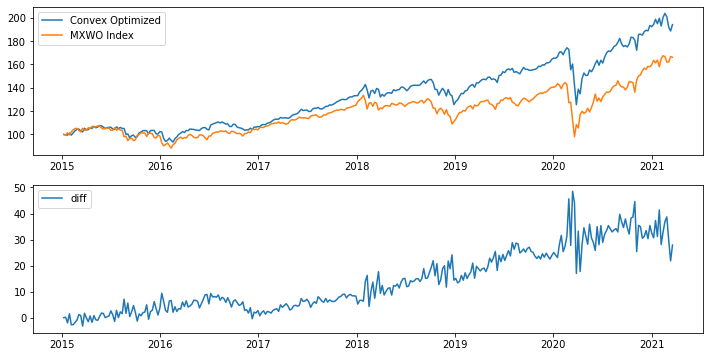

In [8]:
df_comp2 = pd.DataFrame(results[0].v, columns=["Convex Optimized"])
df_EW = pd.DataFrame(results[1].v, columns=["EW Buy and Hold"])
df_comp2 = pd.concat((df_comp2,df_benchmark,df_EW),axis=1).dropna()
df_comp2 = df_comp2.div(df_comp2.iloc[0]) *100
df_comp2["diff"] = df_comp2.iloc[:,0] - df_comp2.iloc[:,1]

plt.figure(figsize=(12,6))

plt.subplot(211)
plt.plot(df_comp2.iloc[:,0], label=df_comp2.columns[0])
plt.plot(df_comp2.iloc[:,1], label=df_comp2.columns[1])
# plt.plot(df_comp2.iloc[:,2], label=df_comp2.columns[2])
plt.legend(loc='upper left')

plt.subplot(212)
plt.plot(df_comp2.iloc[:,3], label=df_comp2.columns[3])
plt.legend(loc='upper left')

### Plotting Convex Optimized portfolio's asset allocation

<AxesSubplot:>

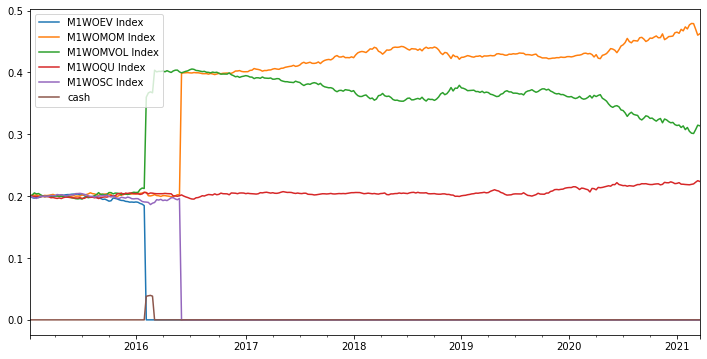

In [9]:
# Plotting weights of optimized portfolio
results[0].w.plot(figsize=(12,6))

### Plotting recommended asset allocation from convex optimized portfolio

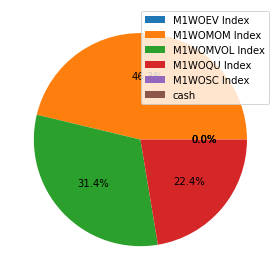

In [10]:
# Plot a pie chart of suggested weights from optimized results
weights = pd.DataFrame((results[0].w*100))
labels = weights.iloc[-1].index
plt.pie(weights.iloc[-1],autopct='%.1f%%')
plt.tight_layout()
plt.legend(labels, loc="upper right")
plt.show()

In [22]:
# Print asset value post-trades (i.e. asset allocation in absolute term)
results[0].h_next

,M1WOEV Index,M1WOMOM Index,M1WOMVOL Index,M1WOQU Index,M1WOSC Index,cash
2015-01-09,19690.634724,20115.638910,20125.719338,19946.115579,19775.508939,0.001130
2015-01-16,19549.041026,20042.694806,20401.523531,19827.676306,19611.926340,0.001017
2015-01-23,20041.390834,20436.591416,20595.261165,20209.403765,19852.659552,0.000770
2015-01-30,19647.329527,19994.644385,20302.632780,19796.333130,19700.678458,0.002249
2015-02-06,20143.201121,20287.356605,20517.879411,20197.400520,20251.754609,0.001114
...,...,...,...,...,...,...
2021-02-19,0.000353,96089.925800,60450.181376,44097.529828,0.000716,0.000725
2021-02-26,0.000391,90120.334486,58998.030121,42676.922837,0.000788,0.000933
2021-03-05,0.000554,86779.440186,59335.878336,42422.171849,0.000997,0.001253
2021-03-12,0.000529,89710.729731,60852.139346,43397.298726,0.001082,0.000997
